# Pareto Frontier Analysis for Insurance Optimization

This notebook demonstrates the use of Pareto frontier analysis for multi-objective optimization in insurance decision making. We'll explore trade-offs between ROE, risk, and insurance costs.

In [1]:
# Setup and imports
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from ergodic_insurance.src.pareto_frontier import (
    Objective, ObjectiveType, ParetoFrontier, ParetoPoint
)
from ergodic_insurance.src.visualization import (
    plot_pareto_frontier_2d,
    plot_pareto_frontier_3d,
    create_interactive_pareto_frontier,
    set_wsj_style
)
from ergodic_insurance.src.manufacturer import WidgetManufacturer
from ergodic_insurance.src.insurance_program import InsuranceProgram, EnhancedInsuranceLayer
from ergodic_insurance.src.simulation import Simulation
from ergodic_insurance.src.config import (
    ManufacturerConfig, GrowthConfig
)

# Set style
set_wsj_style()
print("Pareto Frontier Analysis Module Loaded Successfully")

Pareto Frontier Analysis Module Loaded Successfully


## 1. Basic Pareto Frontier Concepts

First, let's demonstrate basic Pareto frontier concepts with a simple example.

Generated 30 Pareto optimal points using weighted sum


Generated 30 Pareto optimal points using epsilon-constraint


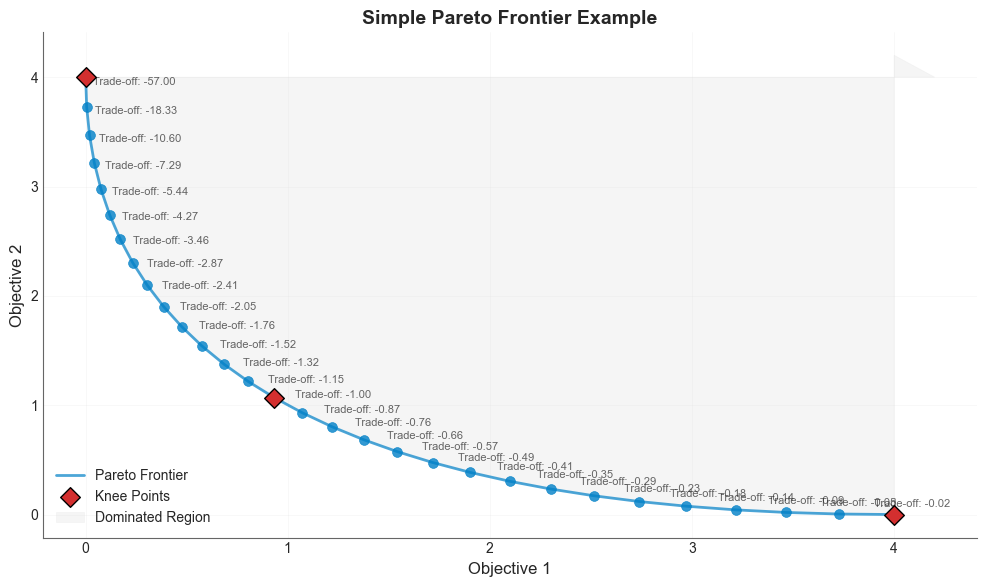

In [2]:
# Create a simple bi-objective problem
def simple_objectives(x):
    """Simple convex Pareto front for demonstration."""
    f1 = x[0]**2
    f2 = (x[0] - 2)**2
    return {"f1": f1, "f2": f2}

# Define objectives
objectives = [
    Objective("f1", ObjectiveType.MINIMIZE),
    Objective("f2", ObjectiveType.MINIMIZE)
]

# Create Pareto frontier
frontier = ParetoFrontier(
    objectives=objectives,
    objective_function=simple_objectives,
    bounds=[(-1, 3)]
)

# Generate frontier using weighted sum method
points_ws = frontier.generate_weighted_sum(n_points=30)
print(f"Generated {len(points_ws)} Pareto optimal points using weighted sum")

# Generate using epsilon-constraint method
points_ec = frontier.generate_epsilon_constraint(n_points=30)
print(f"Generated {len(points_ec)} Pareto optimal points using epsilon-constraint")

# Plot the frontier
fig = plot_pareto_frontier_2d(
    points_ws,
    "f1", "f2",
    x_label="Objective 1",
    y_label="Objective 2",
    title="Simple Pareto Frontier Example",
    highlight_knees=True,
    show_trade_offs=True
)
plt.show()

## 2. Insurance Optimization: ROE vs Risk Trade-off

Now let's apply Pareto analysis to a realistic insurance optimization problem.

In [3]:
# Create insurance optimization objective function
def insurance_objectives(x):
    """
    Insurance optimization objectives.
    x[0]: Retention ratio (0.3 to 1.0)
    x[1]: Premium multiplier (1.0 to 3.0)
    """
    retention = x[0]
    premium_mult = x[1]
    
    # ROE model: higher retention increases ROE, higher premiums decrease it
    base_roe = 0.15
    roe = base_roe * (1 + 0.5 * retention) * (1 - 0.1 * (premium_mult - 1))
    
    # Risk model: higher retention increases risk, higher premiums decrease it
    base_risk = 0.02
    bankruptcy_risk = base_risk * (1 + retention) / (1 + 0.5 * premium_mult)
    
    # Cost model: premiums are a cost
    base_premium = 100000
    insurance_cost = base_premium * premium_mult
    
    return {
        "ROE": roe,
        "bankruptcy_risk": bankruptcy_risk,
        "insurance_cost": insurance_cost
    }

# Define objectives for insurance optimization
insurance_objs = [
    Objective("ROE", ObjectiveType.MAXIMIZE, weight=0.5),
    Objective("bankruptcy_risk", ObjectiveType.MINIMIZE, weight=0.5)
]

# Create frontier
insurance_frontier = ParetoFrontier(
    objectives=insurance_objs,
    objective_function=insurance_objectives,
    bounds=[(0.3, 1.0), (1.0, 3.0)]
)

# Generate Pareto frontier
insurance_points = insurance_frontier.generate_weighted_sum(n_points=50)
print(f"Generated {len(insurance_points)} Pareto optimal insurance strategies")

# Convert to DataFrame for analysis
df_pareto = insurance_frontier.to_dataframe()
print("\nPareto Frontier Statistics:")
print(df_pareto[["ROE", "bankruptcy_risk"]].describe())

Generated 25 Pareto optimal insurance strategies

Pareto Frontier Statistics:
             ROE  bankruptcy_risk
count  25.000000        25.000000
mean    0.199933         0.021414
std     0.035503         0.006657
min     0.138000         0.010400
25%     0.197379         0.018923
50%     0.221707         0.025426
75%     0.225000         0.026667
max     0.225000         0.026667


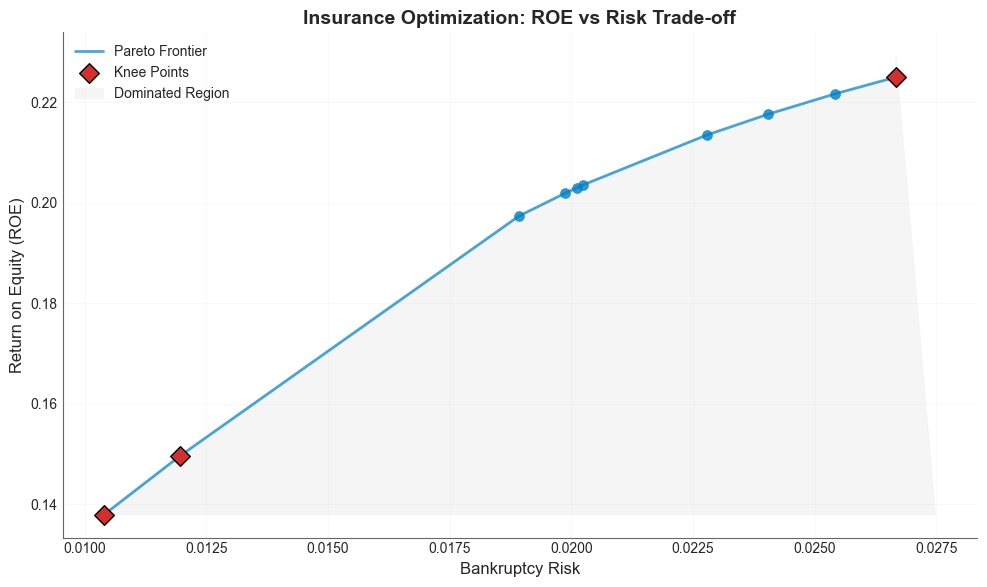


Knee Points (Best Trade-offs):

Knee Point 1:
  ROE: 19.74%
  Bankruptcy Risk: 1.892%
  Retention: 100.0%
  Premium Multiplier: 2.23x

Knee Point 2:
  ROE: 20.19%
  Bankruptcy Risk: 1.986%
  Retention: 100.0%
  Premium Multiplier: 2.03x

Knee Point 3:
  ROE: 20.30%
  Bankruptcy Risk: 2.011%
  Retention: 100.0%
  Premium Multiplier: 1.98x


In [4]:
# Plot ROE vs Risk frontier
fig = plot_pareto_frontier_2d(
    insurance_points,
    "bankruptcy_risk", "ROE",
    x_label="Bankruptcy Risk",
    y_label="Return on Equity (ROE)",
    title="Insurance Optimization: ROE vs Risk Trade-off",
    highlight_knees=True,
    show_trade_offs=False
)
plt.show()

# Find and display knee points
knee_points = insurance_frontier.get_knee_points(n_knees=3)
print("\nKnee Points (Best Trade-offs):")
for i, knee in enumerate(knee_points, 1):
    print(f"\nKnee Point {i}:")
    print(f"  ROE: {knee.objectives['ROE']:.2%}")
    print(f"  Bankruptcy Risk: {knee.objectives['bankruptcy_risk']:.3%}")
    print(f"  Retention: {knee.decision_variables[0]:.1%}")
    print(f"  Premium Multiplier: {knee.decision_variables[1]:.2f}x")

## 3. Three-Objective Optimization: ROE vs Risk vs Cost

Generated 40 Pareto optimal points for 3D frontier


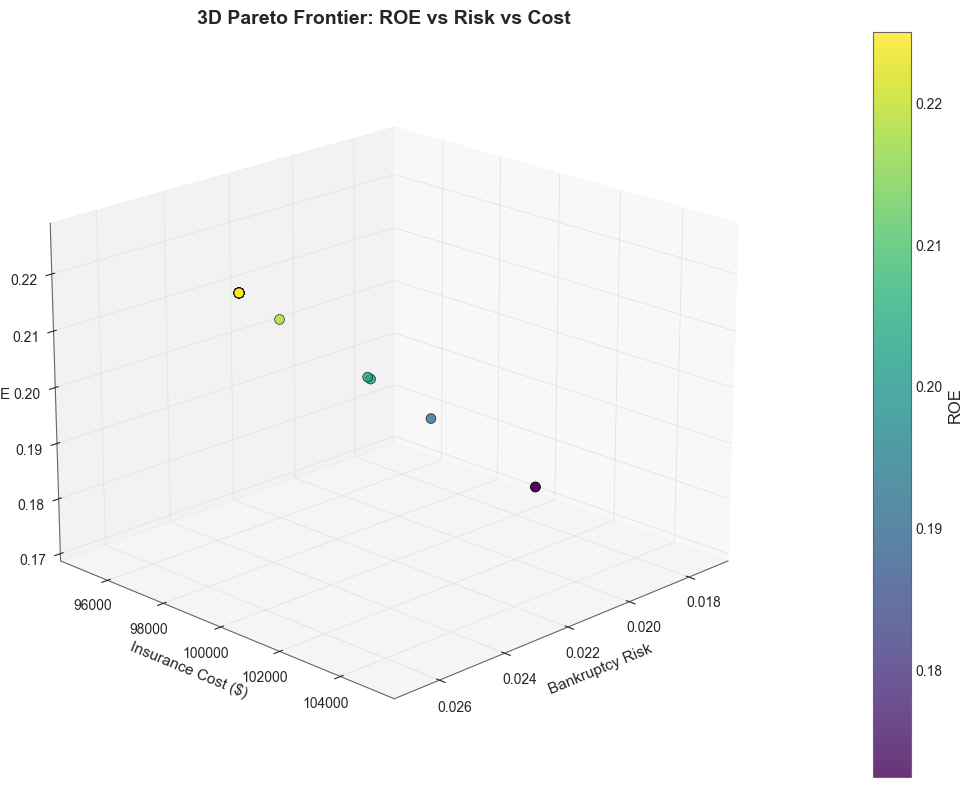

In [5]:
# Three-objective optimization
three_objectives = [
    Objective("ROE", ObjectiveType.MAXIMIZE, weight=0.4),
    Objective("bankruptcy_risk", ObjectiveType.MINIMIZE, weight=0.3),
    Objective("insurance_cost", ObjectiveType.MINIMIZE, weight=0.3)
]

# Create 3D frontier
frontier_3d = ParetoFrontier(
    objectives=three_objectives,
    objective_function=insurance_objectives,
    bounds=[(0.3, 1.0), (1.0, 3.0)]
)

# Generate points
points_3d = frontier_3d.generate_evolutionary(
    n_generations=50,
    population_size=40
)
print(f"Generated {len(points_3d)} Pareto optimal points for 3D frontier")

# Plot 3D frontier
fig = plot_pareto_frontier_3d(
    points_3d,
    "bankruptcy_risk", "insurance_cost", "ROE",
    x_label="Bankruptcy Risk",
    y_label="Insurance Cost ($)",
    z_label="ROE",
    title="3D Pareto Frontier: ROE vs Risk vs Cost"
)
plt.show()

In [6]:
# Create interactive 3D visualization
interactive_fig = create_interactive_pareto_frontier(
    points_3d,
    ["bankruptcy_risk", "insurance_cost", "ROE"],
    title="Interactive 3D Pareto Frontier",
    height=600
)
interactive_fig.show()

## 4. Integration with Decision Engine

Let's integrate the Pareto frontier with the actual insurance decision engine.

In [7]:
from ergodic_insurance.src.decision_engine import InsuranceDecisionEngine
from ergodic_insurance.src.config_loader import ConfigLoader

# Load configuration
config_loader = ConfigLoader()
config = config_loader.load("baseline")

# Create manufacturer using the config object directly
manufacturer = WidgetManufacturer(config.manufacturer)

# Define decision engine objective function
def decision_engine_objectives(x):
    """
    Use actual decision engine to evaluate objectives.
    x[0:3]: Layer limits (millions)
    x[3:6]: Layer attachments (millions)
    """
    # Create insurance program from decision variables
    layers = []
    for i in range(3):
        if x[i] > 0.01:  # Only add layer if limit > 10k
            layer = EnhancedInsuranceLayer(
                limit=x[i] * 1e6,
                attachment_point=x[i+3] * 1e6,  
                premium_rate=0.02 - 0.005 * i  # Decreasing rates by layer
            )
            layers.append(layer)
    
    if not layers:
        # No insurance case
        return {"ROE": 0.08, "risk": 0.10, "total_premium": 0}
    
    program = InsuranceProgram(layers=layers)
    
    # Simple evaluation (would normally run simulation)
    total_premium = program.calculate_annual_premium()  # Changed from calculate_total_premium
    total_limit = sum(layer.limit for layer in layers)
    
    # Simplified metrics
    roe = 0.12 * (1 - total_premium / 5e6)  # ROE decreases with premium
    risk = 0.05 / (1 + total_limit / 10e6)  # Risk decreases with coverage
    
    return {
        "ROE": roe,
        "risk": risk,
        "total_premium": total_premium
    }

# Define objectives
decision_objectives = [
    Objective("ROE", ObjectiveType.MAXIMIZE, weight=0.5),
    Objective("risk", ObjectiveType.MINIMIZE, weight=0.5)
]

# Bounds for decision variables (in millions)
decision_bounds = [
    (0, 5),    # Layer 1 limit
    (0, 10),   # Layer 2 limit
    (0, 20),   # Layer 3 limit
    (0, 1),    # Layer 1 attachment
    (1, 5),    # Layer 2 attachment
    (5, 10),   # Layer 3 attachment
]

# Create frontier
decision_frontier = ParetoFrontier(
    objectives=decision_objectives,
    objective_function=decision_engine_objectives,
    bounds=decision_bounds
)

# Generate frontier
decision_points = decision_frontier.generate_evolutionary(
    n_generations=30,
    population_size=20
)

print(f"Generated {len(decision_points)} optimal insurance structures")

Generated 20 optimal insurance structures


Best ROE Structure:
  ROE: 11.87%
  Risk: 3.242%
  Premium: $54,207
  Layer Limits (M): [0.0, 0.0, 5.4]

Lowest Risk Structure:
  ROE: 10.92%
  Risk: 1.111%
  Premium: $450,000
  Layer Limits (M): [5.0, 10.0, 20.0]


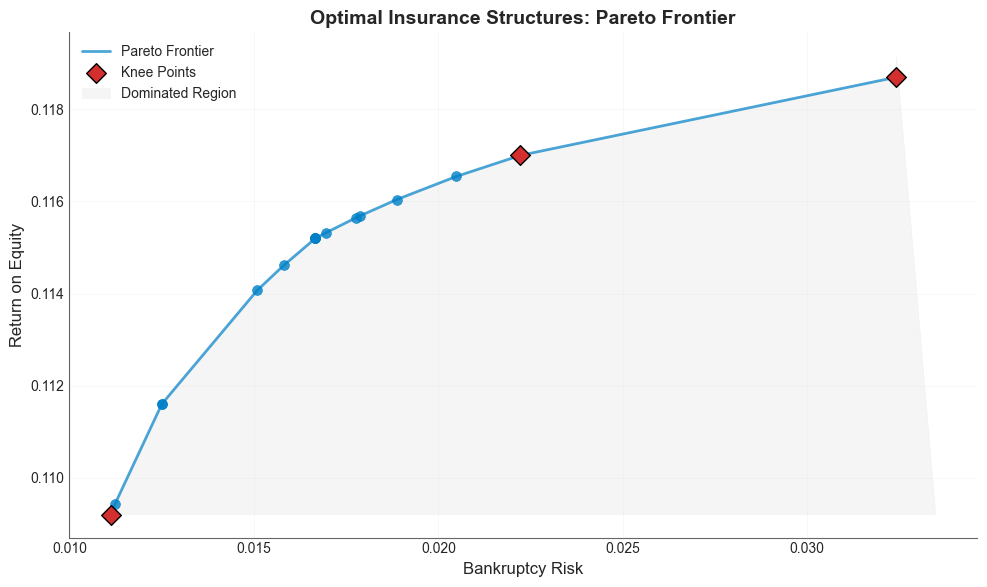

In [8]:
# Analyze optimal structures
df_structures = decision_frontier.to_dataframe()

# Find best structures
best_roe_idx = df_structures['ROE'].idxmax()
best_risk_idx = df_structures['risk'].idxmin()

print("Best ROE Structure:")
best_roe = df_structures.loc[best_roe_idx]
print(f"  ROE: {best_roe['ROE']:.2%}")
print(f"  Risk: {best_roe['risk']:.3%}")
print(f"  Premium: ${best_roe['total_premium']:,.0f}")
print(f"  Layer Limits (M): [{best_roe['decision_var_0']:.1f}, "
      f"{best_roe['decision_var_1']:.1f}, {best_roe['decision_var_2']:.1f}]")

print("\nLowest Risk Structure:")
best_risk = df_structures.loc[best_risk_idx]
print(f"  ROE: {best_risk['ROE']:.2%}")
print(f"  Risk: {best_risk['risk']:.3%}")
print(f"  Premium: ${best_risk['total_premium']:,.0f}")
print(f"  Layer Limits (M): [{best_risk['decision_var_0']:.1f}, "
      f"{best_risk['decision_var_1']:.1f}, {best_risk['decision_var_2']:.1f}]")

# Plot frontier
fig = plot_pareto_frontier_2d(
    decision_points,
    "risk", "ROE",
    x_label="Bankruptcy Risk",
    y_label="Return on Equity",
    title="Optimal Insurance Structures: Pareto Frontier",
    highlight_knees=True
)
plt.show()

## 5. Hypervolume and Frontier Quality Metrics

Frontier Generation Methods Comparison:
------------------------------------------------------------
Weighted Sum         | Points:  14 | Hypervolume: 0.0003
Epsilon-Constraint   | Points:  30 | Hypervolume: 0.0001
Evolutionary         | Points:  30 | Hypervolume: 0.0003


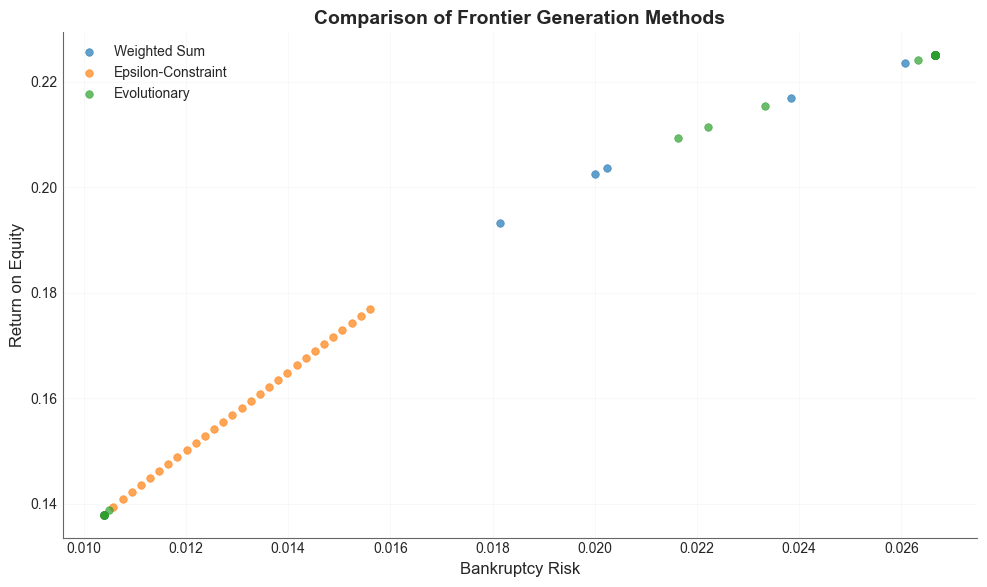

In [9]:
# Calculate hypervolume for different frontier generation methods
methods_comparison = {}

# Weighted sum method
frontier_ws = ParetoFrontier(
    objectives=insurance_objs,
    objective_function=insurance_objectives,
    bounds=[(0.3, 1.0), (1.0, 3.0)]
)
points_ws = frontier_ws.generate_weighted_sum(n_points=30)
hv_ws = frontier_ws.calculate_hypervolume()
methods_comparison['Weighted Sum'] = {'points': len(points_ws), 'hypervolume': hv_ws}

# Epsilon-constraint method
frontier_ec = ParetoFrontier(
    objectives=insurance_objs,
    objective_function=insurance_objectives,
    bounds=[(0.3, 1.0), (1.0, 3.0)]
)
points_ec = frontier_ec.generate_epsilon_constraint(n_points=30)
hv_ec = frontier_ec.calculate_hypervolume()
methods_comparison['Epsilon-Constraint'] = {'points': len(points_ec), 'hypervolume': hv_ec}

# Evolutionary method
frontier_ev = ParetoFrontier(
    objectives=insurance_objs,
    objective_function=insurance_objectives,
    bounds=[(0.3, 1.0), (1.0, 3.0)]
)
points_ev = frontier_ev.generate_evolutionary(n_generations=50, population_size=30)
hv_ev = frontier_ev.calculate_hypervolume()
methods_comparison['Evolutionary'] = {'points': len(points_ev), 'hypervolume': hv_ev}

# Display comparison
print("Frontier Generation Methods Comparison:")
print("-" * 60)
for method, metrics in methods_comparison.items():
    print(f"{method:20s} | Points: {metrics['points']:3d} | Hypervolume: {metrics['hypervolume']:.4f}")

# Plot all frontiers for comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each frontier
for method, frontier_points in [("Weighted Sum", points_ws),
                                  ("Epsilon-Constraint", points_ec),
                                  ("Evolutionary", points_ev)]:
    x_vals = [p.objectives["bankruptcy_risk"] for p in frontier_points]
    y_vals = [p.objectives["ROE"] for p in frontier_points]
    ax.scatter(x_vals, y_vals, label=method, alpha=0.7, s=30)

ax.set_xlabel("Bankruptcy Risk", fontsize=12)
ax.set_ylabel("Return on Equity", fontsize=12)
ax.set_title("Comparison of Frontier Generation Methods", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Sensitivity Analysis of Pareto Frontier

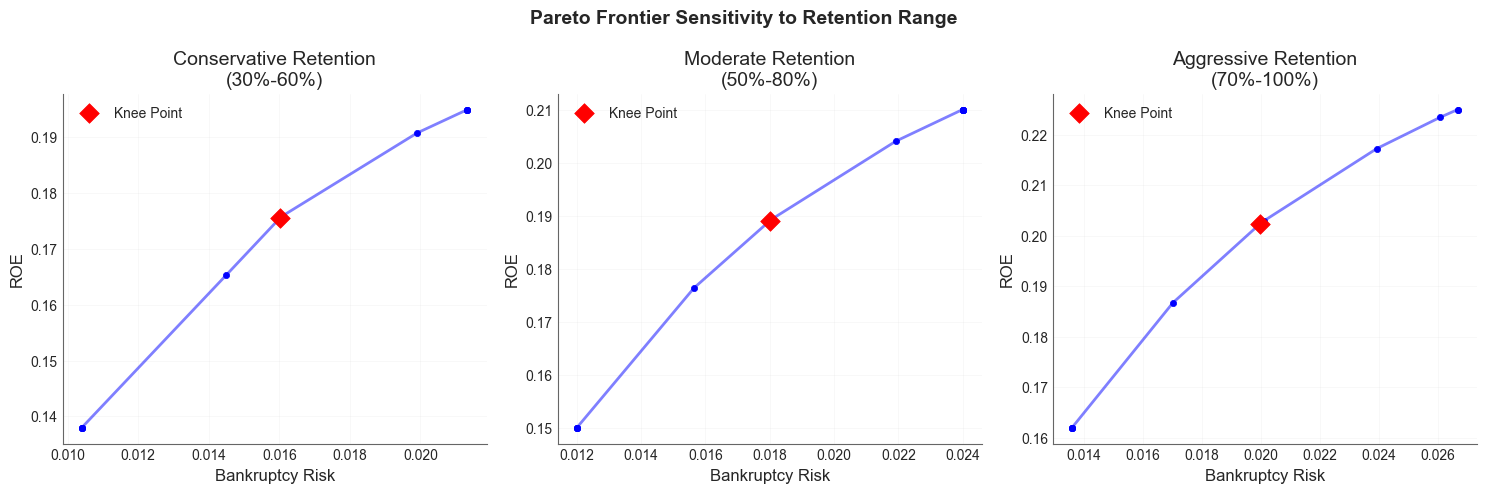


Sensitivity Analysis Results:
------------------------------------------------------------

Conservative Strategy:
  Hypervolume: 0.0002
  Knee Point ROE: 17.56%
  Knee Point Risk: 1.603%

Moderate Strategy:
  Hypervolume: 0.0002
  Knee Point ROE: 18.90%
  Knee Point Risk: 1.800%

Aggressive Strategy:
  Hypervolume: 0.0003
  Knee Point ROE: 20.23%
  Knee Point Risk: 1.997%


In [10]:
# Analyze how frontier changes with different parameter ranges
sensitivity_results = {}

# Different retention ranges
retention_ranges = [
    (0.3, 0.6, "Conservative"),
    (0.5, 0.8, "Moderate"),
    (0.7, 1.0, "Aggressive")
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (min_ret, max_ret, label) in enumerate(retention_ranges):
    # Create frontier with different bounds
    frontier_sens = ParetoFrontier(
        objectives=insurance_objs,
        objective_function=insurance_objectives,
        bounds=[(min_ret, max_ret), (1.0, 3.0)]
    )
    
    points_sens = frontier_sens.generate_weighted_sum(n_points=30)
    
    # Store results
    sensitivity_results[label] = {
        'points': points_sens,
        'hypervolume': frontier_sens.calculate_hypervolume(),
        'knee_points': frontier_sens.get_knee_points(n_knees=1)
    }
    
    # Plot
    ax = axes[idx]
    x_vals = [p.objectives["bankruptcy_risk"] for p in points_sens]
    y_vals = [p.objectives["ROE"] for p in points_sens]
    
    ax.plot(x_vals, y_vals, 'b-', alpha=0.5)
    ax.scatter(x_vals, y_vals, c='blue', s=20)
    
    # Highlight knee point
    if sensitivity_results[label]['knee_points']:
        knee = sensitivity_results[label]['knee_points'][0]
        ax.scatter(
            knee.objectives["bankruptcy_risk"],
            knee.objectives["ROE"],
            color='red', s=100, marker='D', zorder=5,
            label='Knee Point'
        )
    
    ax.set_xlabel("Bankruptcy Risk")
    ax.set_ylabel("ROE")
    ax.set_title(f"{label} Retention\n({min_ret:.0%}-{max_ret:.0%})")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle("Pareto Frontier Sensitivity to Retention Range", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print sensitivity metrics
print("\nSensitivity Analysis Results:")
print("-" * 60)
for label, results in sensitivity_results.items():
    knee = results['knee_points'][0] if results['knee_points'] else None
    print(f"\n{label} Strategy:")
    print(f"  Hypervolume: {results['hypervolume']:.4f}")
    if knee:
        print(f"  Knee Point ROE: {knee.objectives['ROE']:.2%}")
        print(f"  Knee Point Risk: {knee.objectives['bankruptcy_risk']:.3%}")

## 7. Interactive Dashboard for Decision Making

In [11]:
# Create comprehensive dashboard with multiple views
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Use the 3D frontier points for comprehensive analysis
df_full = frontier_3d.to_dataframe()

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "ROE vs Risk",
        "ROE vs Cost",
        "Risk vs Cost",
        "Decision Variables"
    ),
    specs=[
        [{"type": "scatter"}, {"type": "scatter"}],
        [{"type": "scatter"}, {"type": "scatter"}]
    ]
)

# ROE vs Risk
fig.add_trace(
    go.Scatter(
        x=df_full['bankruptcy_risk'],
        y=df_full['ROE'],
        mode='markers',
        marker=dict(color=df_full['crowding_distance'], colorscale='Viridis'),
        name='Solutions',
        text=[f"Point {i}" for i in range(len(df_full))],
        hovertemplate="Risk: %{x:.3f}<br>ROE: %{y:.3f}<extra></extra>"
    ),
    row=1, col=1
)

# ROE vs Cost
fig.add_trace(
    go.Scatter(
        x=df_full['insurance_cost'],
        y=df_full['ROE'],
        mode='markers',
        marker=dict(color=df_full['crowding_distance'], colorscale='Viridis'),
        name='Solutions',
        showlegend=False,
        hovertemplate="Cost: $%{x:,.0f}<br>ROE: %{y:.3f}<extra></extra>"
    ),
    row=1, col=2
)

# Risk vs Cost
fig.add_trace(
    go.Scatter(
        x=df_full['insurance_cost'],
        y=df_full['bankruptcy_risk'],
        mode='markers',
        marker=dict(color=df_full['crowding_distance'], colorscale='Viridis'),
        name='Solutions',
        showlegend=False,
        hovertemplate="Cost: $%{x:,.0f}<br>Risk: %{y:.3f}<extra></extra>"
    ),
    row=2, col=1
)

# Decision Variables (Retention vs Premium Multiplier)
fig.add_trace(
    go.Scatter(
        x=df_full['decision_var_0'],  # Retention
        y=df_full['decision_var_1'],  # Premium multiplier
        mode='markers',
        marker=dict(color=df_full['ROE'], colorscale='RdYlGn'),
        name='Solutions',
        showlegend=False,
        hovertemplate="Retention: %{x:.1%}<br>Premium Mult: %{y:.2f}x<extra></extra>"
    ),
    row=2, col=2
)

# Update layout
fig.update_xaxes(title_text="Bankruptcy Risk", row=1, col=1)
fig.update_yaxes(title_text="ROE", row=1, col=1)
fig.update_xaxes(title_text="Insurance Cost ($)", row=1, col=2)
fig.update_yaxes(title_text="ROE", row=1, col=2)
fig.update_xaxes(title_text="Insurance Cost ($)", row=2, col=1)
fig.update_yaxes(title_text="Bankruptcy Risk", row=2, col=1)
fig.update_xaxes(title_text="Retention Ratio", row=2, col=2)
fig.update_yaxes(title_text="Premium Multiplier", row=2, col=2)

fig.update_layout(
    height=800,
    title_text="Pareto Frontier Analysis Dashboard",
    showlegend=True,
    template="plotly_white"
)

fig.show()

## Summary

This notebook demonstrated comprehensive Pareto frontier analysis for insurance optimization:

1. **Basic Concepts**: Illustrated Pareto optimality and dominance
2. **Bi-objective Optimization**: ROE vs Risk trade-offs
3. **Three-objective Analysis**: Including cost as a third dimension
4. **Integration**: Connected with the insurance decision engine
5. **Quality Metrics**: Hypervolume and knee point analysis
6. **Sensitivity Analysis**: How parameter ranges affect the frontier
7. **Interactive Visualization**: Multi-dimensional decision support

Key insights:
- Pareto frontiers reveal the fundamental trade-offs in insurance decisions
- Knee points identify solutions with balanced performance
- Different generation methods produce similar but not identical frontiers
- Interactive visualizations help decision-makers explore options